# БОТ, СОЗДАЮЩИЙ ОБЛАКА СЛОВ

In [1]:
pip install https://github.com/aiogram/aiogram/archive/refs/heads/dev-3.x.zip

Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/aiogram/aiogram/archive/refs/heads/dev-3.x.zip
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nest_asyncio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pymorphy3

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=0375329f0beab32aa1037713c7d1d95489de3ceba2d0c32d2e6139a4c461b953
  Stored in directory: c:\users\klim\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [28]:
import os
import nest_asyncio
import asyncio
import logging
from aiogram import Bot, Dispatcher, types, filters, Router, handlers, F
from aiogram.filters import Command
from aiogram.types import FSInputFile

import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation

from pymorphy3 import MorphAnalyzer
pymorphy3_analyzer = MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Klim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def prepare(infile, switch):
    if switch == 'channel':
        with open(infile, 'r', encoding='utf8') as f:
            jdata = f.read()
        data = json.loads(jdata)
        messages = data['messages']
        df = pd.DataFrame(messages)
        df['text'] = df['text'].apply(lambda x: [i for i in x if type(i) == str] if type(x) == list else x)
        df['text'] = df['text'].astype('str')
        df['text'].replace(r'\\n', ' ', regex=True, inplace=True)
        df['text'].replace(r'\n', ' ', regex=True, inplace=True)
        text = ' '.join(df['text'].to_list()).lower()
    elif switch == 'txt':
        with open(infile, 'r', encoding='utf8') as f:
            text = f.read().lower().replace('\n', ' ')
    return text

def cloud(text, infile):
    text_masked = ' '.join([pymorphy3_analyzer.parse(word)[0].normal_form for word in text.split() if
                            pymorphy3_analyzer.parse(word)[0].tag.POS == 'NOUN'])
    noise = stopwords.words('russian')
    punctuation_new = list(punctuation) + list('»') + list('«')
    wordcloud = WordCloud(stopwords=noise + punctuation_new + ['мочь', 'который', 'свой', 'весь'], 
                          mode='RGBA', background_color=None).generate(text_masked)
    outfile = infile.replace('json', 'png').replace('txt', 'png')
    wordcloud.to_file(outfile)
    return outfile

In [46]:
nest_asyncio.apply()

logging.basicConfig(level=logging.INFO)

TOKEN = '5930567047:AAFUeBgC1hDCaay14Sr47NjdBU8ZLkNQta0'

async def main():
    bot = Bot(token=TOKEN)
    global switch
    switch = 'off'
    dp = Dispatcher()
    dp.include_router(router)
    await bot.delete_webhook(drop_pending_updates=True)
    await dp.start_polling(bot)

router = Router()

@router.message(Command('start'))
async def start(message): 
    global switch
    switch = 'off'
    kb = [
        [types.KeyboardButton(text='Telegram канал/чат')],
        [types.KeyboardButton(text='Текстовый файл (с расширением .txt)')],
        [types.KeyboardButton(text='Спасибо, не надо облаков.')]
    ]
    keyboard = types.ReplyKeyboardMarkup(keyboard=kb, resize_keyboard=True, one_time_keyboard=True)
    await message.answer_sticker(r'CAACAgUAAxkBAAEGlihjhJzOCae5KywwFe850cZstkjtawACtQUAAqMFQQctHaXKG0pkxysE')
    await message.answer('Здравствуйте.\nМеня зовут Клауди и я делаю облака слов.\n\
Что Вы хотите превратить в облако?', reply_markup=keyboard)

@router.message(lambda message: message.text == 'Telegram канал/чат')
async def option_channel(message):
    global switch
    switch = 'channel'
    await message.answer('Экспортируйте историю канала/чата в формате JSON\
 (данная функция доступна только в Telegram Desktop) и \
вставьте в сообщение ниже.\n\nВведите любое сообщение, чтобы начать заново.')
    
@router.message(lambda message: message.text == 'Текстовый файл (с расширением .txt)')
async def option_txt(message):
    global switch
    switch = 'txt'
    await message.answer('Вставьте текстовый файл в сообщение ниже.\nЧем чище файл, тем красивее облако.\n\n\
Введите любое сообщение, чтобы начать заново.')

@router.message(~F.content_type.in_({'text'}))
async def inout(message, bot):
    if switch in ['channel', 'txt']:
        infile_error = False
        try:
            os.makedirs(f'{os.getcwd()}\\cloudy_files', exist_ok=True)
            if switch == 'channel':
                extension = '.json'
            elif switch == 'txt':
                extension = '.txt' 
            infile = f'{os.getcwd()}\\cloudy_files\\{message.document.file_id}{extension}'
            await bot.download(message.document, destination=infile)
            await message.answer_sticker(r'CAACAgUAAxkBAAEGmAxjhOd0fyuNg24ngDHR_mMZLWeGqQAC-QUAAqMFQQeMBfF0g8QOLisE')
            await message.answer('Делаю облако.\nВам необязательно здесь ждать. Я пришлю результат с вороном.')
            text = prepare(infile, switch)
        except:
            infile_error = True
            await message.answer_sticker(r'CAACAgUAAxkBAAEGn0ljhvkqvM96D6icF-IyO9Zxr5O49wAC5wUAAqMFQQfz3mvY5aG69CsE')
            if switch == 'json':
                await message.answer('Не получается обработать файл.\nВставьте экспорт канала/чата\
 в формате JSON.\n\nВведите любое сообщение, чтобы начать заново.')
            if switch == 'txt':
                await message.answer('Не получается обработать файл.\nВставьте текстовый файл\
 с расширением .txt.\n\nВведите любое сообщение, чтобы начать заново.')
        if infile_error == False:
            try:
                outfile = cloud(text, infile)
                result = FSInputFile(outfile)
                await message.answer_photo(result)
                await message.answer('Ваше облако готово.\nЕсли хотите ещё одно, вставьте новый файл.\n\n\
Введите любое сообщение, чтобы начать заново.')
            except:
                await message.answer_sticker(r'CAACAgUAAxkBAAEGn0tjhvnDHh3GjdC946_BOYClWEZ7BQACuQUAAqMFQQfoxuUFtV3sGisE')
                await message.answer('Что-то сломалось. Попробуйте вставить другой файл в формате JSON.\n\n\
Введите любое сообщение, чтобы начать заново.')
    else:
        kb = [
        [types.KeyboardButton(text='/start')],
        [types.KeyboardButton(text='/help (в разработке)')]
        ]
        keyboard = types.ReplyKeyboardMarkup(keyboard=kb, resize_keyboard=True, one_time_keyboard=True)
        await message.answer_sticker(r'CAACAgUAAxkBAAEGn99jh1oHZzET1tjBRiN3w_6ru1-TBAAC4QUAAqMFQQdMy6ISqoHknCsE')
        await message.answer('Нельзя просто прийти и что-то в меня кинуть.\nСначала надо поздороваться.')
        await message.answer('Нажмите /start, чтобы начать общение.\n\
Нажмите /help, чтобы узнать обо мне.', reply_markup=keyboard)
    
@router.message(lambda message: message.text == 'Спасибо, не надо облаков.')
async def cancel(message):
    global switch
    switch = 'off'
    await message.answer_sticker(r'CAACAgUAAxkBAAEGli5jhJ3TB9AIa1XroQQlRAlSvbXrBQAC8QUAAqMFQQeTfXHOdOBBJysE')
    await message.answer('Понимаю.\n\nВведите любое сообщение, если захотите делать облака.')
    
@router.message(Command('help'))
async def about(message): 
    global switch
    switch = 'off'
    await message.answer_sticker(r'CAACAgUAAxkBAAEGn-Vjh1qEke0WNzojT5J6kGUttB0idgACxQUAAqMFQQd6VxpupFr34SsE')
    await message.answer('Понимаю.\n\nВведите любое сообщение, если захотите делать облака.')
       
@router.message()
async def every(message):
    global switch
    switch = 'off'
    kb = [
        [types.KeyboardButton(text='/start')],
        [types.KeyboardButton(text='/help (в разработке)')]
    ]
    keyboard = types.ReplyKeyboardMarkup(keyboard=kb, resize_keyboard=True, one_time_keyboard=True)
    await message.answer('Нажмите /start, чтобы начать общение.\n\
Нажмите /help, чтобы узнать обо мне.', reply_markup=keyboard)

if __name__ == "__main__":
    asyncio.run(main())

INFO:aiogram.dispatcher:Start polling
INFO:aiogram.dispatcher:Run polling for bot @very_cloudy_bot id=5930567047 - 'Cloudy'
INFO:aiogram.event:Update id=983441739 is handled. Duration 250 ms by bot id=5930567047
INFO:aiogram.event:Update id=983441740 is handled. Duration 327 ms by bot id=5930567047
INFO:aiogram.event:Update id=983441741 is handled. Duration 141 ms by bot id=5930567047
INFO:aiogram.dispatcher:Polling stopped


KeyboardInterrupt: 

In [3]:
with open(infile, 'r', encoding='utf8') as f:
            jdata = f.read()
        data = json.loads(jdata)
        messages = data['messages']
        df = pd.DataFrame(messages)
        df['text'] = df['text'].apply(lambda x: [i for i in x if type(i) == str] if type(x) == list else x)
        df['text'] = df['text'].astype('str')
        df['text'].replace(r'\\n', ' ', regex=True, inplace=True)
        df['text'].replace(r'\n', ' ', regex=True, inplace=True)
        text = " ".join(df['text'].to_list()).lower()
        
        
        
        
    return text

def cloud(text, infile):
    text_masked = ' '.join([pymorphy3_analyzer.parse(word)[0].normal_form for word in text.split() if
                            pymorphy3_analyzer.parse(word)[0].tag.POS == 'NOUN'])
    noise = stopwords.words('russian')
    punctuation_new = list(punctuation) + list('»') + list('«')
    wordcloud = WordCloud(stopwords=noise + punctuation_new + ['мочь', 'который', 'свой', 'весь'], 
                          mode='RGBA', background_color=None).generate(text_masked)
    outfile = infile.replace('json', 'png').replace('txt', 'png')
    wordcloud.to_file(outfile)
    return outfile

In [20]:
with open('Школа в Кармартене.txt', 'r', encoding='utf8') as f:
    text = f.read().lower().replace('\n', ' ')

774750

In [21]:
tdata[:1000]

'а.а. коростелёва  школа в кармартене        в школу мерлина в кармартéне принимали всякого, кто сумел найти ее, войти в нее, разыскать там профессора мерлина и ответить ему по билету. затрепанный этот экзаменационный билет мерлин выуживал каждый раз из складок своего балахона, всегда один и тот же, и прав будет тот, кто предположит, что он десятилетиями не менялся. остальные повсеместно известные требования - шестнадцать лет, знание латыни, не сопливый нос и чистый носовой платок в левом нагрудном кармане - были факультативны.    гвидиóн пришел в школу пешком, с посохом и котомкой, в хороших очень штанах из овечьей шерсти, и пусть будет совестно тому, кто скажет, что штаны эти были немодного покроя. в темных глазах гвидиона отражалась готовность ответить на любые вопросы билета, завести носовой платок и в конечном счете даже нагрудный карман, если это станет камнем преткновения. прием гвидиона стал первым и единственным исключением за всю историю школы в кармартене. в день, когда он в

In [29]:
text_masked = ' '.join([pymorphy3_analyzer.parse(word)[0].normal_form for word in text.split() if
                            pymorphy3_analyzer.parse(word)[0].tag.POS == 'NOUN'])

In [32]:
noise = stopwords.words('russian')
punctuation_new = list(punctuation) + list('»') + list('«')
wordcloud = WordCloud(stopwords=noise + punctuation_new + ['мочь', 'который', 'свой', 'весь'], 
                      mode='RGBA', background_color=None).generate(text_masked)

In [30]:
text_masked[:1000]

'коростелёв школа кармартен школа мерлина кармартéич профессор мерлина билет мерлина раз складка право десятилетие требование знание нос платок карман гвидиóн школа посох штаны штаны глаз гвидион готовность вопрос платок счёт камень приём гвидион исключение история школа школа площадь мерлина отлучка отъезд мел стена экзамен гвидион волос расписание стена профессор орбилия тарквиния змейк профессор сын наследие профессор дочь дочь профессор мэлдун профессор сын студент приложение гвидион архивариус хлодвиг нахтфогель профессор искусство доктор мак карх поэзия туата литература гвидион семинар (примета мак карх преподаватель гвидион холл расписание башня четверть раз занятие медицина доктор диана мак гвидион здание арка внешность башня степень вид башенка школа просторечие имя башня школа смущение башня энтони южанин башня гвидион четверть зубец форма герб девиз гвидион символ доктор диана мак доктор волос время операция причина операция возможность волос мак кехт девочка время волос мак

In [24]:
ldata = ' '.join(tdata.split())

In [26]:
ldata[:1000]

'а.а. коростелёва школа в кармартене в школу мерлина в кармартéне принимали всякого, кто сумел найти ее, войти в нее, разыскать там профессора мерлина и ответить ему по билету. затрепанный этот экзаменационный билет мерлин выуживал каждый раз из складок своего балахона, всегда один и тот же, и прав будет тот, кто предположит, что он десятилетиями не менялся. остальные повсеместно известные требования - шестнадцать лет, знание латыни, не сопливый нос и чистый носовой платок в левом нагрудном кармане - были факультативны. гвидиóн пришел в школу пешком, с посохом и котомкой, в хороших очень штанах из овечьей шерсти, и пусть будет совестно тому, кто скажет, что штаны эти были немодного покроя. в темных глазах гвидиона отражалась готовность ответить на любые вопросы билета, завести носовой платок и в конечном счете даже нагрудный карман, если это станет камнем преткновения. прием гвидиона стал первым и единственным исключением за всю историю школы в кармартене. в день, когда он вошел в горо

In [4]:
text = ' '.join(tdata.split(' ')).lower()

In [5]:
text[:20]

'а.а. коростелёва\n\nшк'

In [ ]:
text = " ".join(df['text'].to_list()).lower()

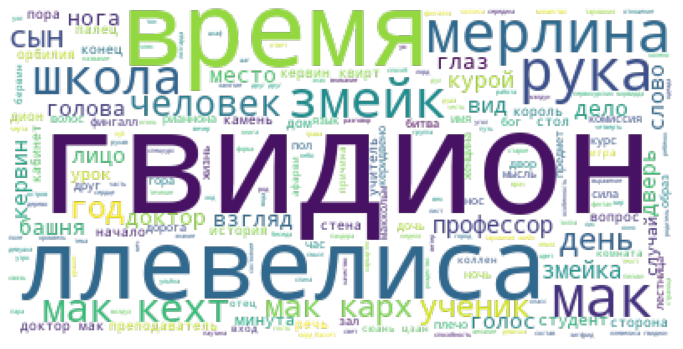

In [33]:
plt.figure(figsize=[12,8])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [113]:
pymorphy3_analyzer.parse('мой')

[Parse(word='мой', tag=OpencorporaTag('ADJF,Apro masc,sing,nomn'), normal_form='мой', score=0.5, methods_stack=((DictionaryAnalyzer(), 'мой', 2048, 0),)),
 Parse(word='мой', tag=OpencorporaTag('ADJF,Apro inan,masc,sing,accs'), normal_form='мой', score=0.25, methods_stack=((DictionaryAnalyzer(), 'мой', 2048, 3),)),
 Parse(word='мой', tag=OpencorporaTag('VERB,impf,tran sing,impr,excl'), normal_form='мыть', score=0.25, methods_stack=((DictionaryAnalyzer(), 'мой', 2073, 11),))]

In [85]:
tag = pymorphy3_analyzer.parse('стали')[0].tag

In [96]:
str(tag).find('NOUN')

-1

In [ ]:
main_parts = ['NOUN', 'ADJF', 'VERB', 'ADVB']

In [148]:
text_masked = ' '.join([pymorphy3_analyzer.parse(word)[0].normal_form for word in text.split() if 
                pymorphy3_analyzer.parse(word)[0].tag.POS == 'NOUN'])

ERROR:aiogram.dispatcher:Failed to fetch updates - TelegramNetworkError: Request timeout error
INFO:aiogram.dispatcher:Connection established (tryings = 1, bot id = 5930567047)


In [ ]:
str(pymorphy3_analyzer.parse(word)[0].tag).split(',')[0]